In [1]:
## This code looks at a single track and plots
## the Chord Length and Lead Width distributions

import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib
import xarray as xr
import load_in_beam
import FSDutil
import seaborn as sns
import ice_plot
import cartopy.crs as ccrs
import os

In [2]:
ATL07file='processed_ATL07-01_20181202120647_09910101_001_01.h5'
# ATL07file='processed_ATL07-01_20181206115828_10520101_001_01.h5'
localFilePath='/home/jovyan/Data/'+ATL07file

In [3]:
namer = ['gt1l','gt1r','gt2r','gt2l','gt3l','gt3r'] # 
# weak beams are 'gt1l', 'gt2l', 'gt3l'
# 'gt3r' is missing a field

CLD = []
LWD = []
latlead = []
latfloe = []
lonlead = []
lonfloe = []

for beam_ind in range(len(namer)):

    beam_data = load_in_beam.read_beam(filename=localFilePath,beam=namer[beam_ind]);
    newCLD,new_latfloe,new_lonfloe = FSDutil.get_CLD(beam_data)
    newLWD,new_latlead,new_lonlead = FSDutil.get_LWD(beam_data)
    
    CLD = np.concatenate([CLD,newCLD])
    LWD = np.concatenate([LWD,newLWD])
    latlead = np.concatenate([latlead,new_latlead])
    lonlead = np.concatenate([lonlead,new_lonlead])
    latfloe = np.concatenate([latfloe,new_latfloe])
    lonfloe = np.concatenate([lonfloe,new_lonfloe])
    

/home/jovyan/Data/processed_ATL07-01_20181202120647_09910101_001_01.h5
/home/jovyan/Data/processed_ATL07-01_20181202120647_09910101_001_01.h5
/home/jovyan/Data/processed_ATL07-01_20181202120647_09910101_001_01.h5
/home/jovyan/Data/processed_ATL07-01_20181202120647_09910101_001_01.h5
/home/jovyan/Data/processed_ATL07-01_20181202120647_09910101_001_01.h5
/home/jovyan/Data/processed_ATL07-01_20181202120647_09910101_001_01.h5


In [17]:
# Load in concentration data

nrt_dir = '/home/jovyan/Data/NSIDC_0081/'

# Get recent observations NH only
ds_81 = xr.open_mfdataset(nrt_dir+'/*.nc', concat_dim='time', autoclose=True, parallel=True)
cd = beam_data.time[0].values  # get the first time in our track
cd = pd.to_datetime(cd).strftime('%Y-%m-%d') # convert time format to get rid of seconds
print('Got the sea ice obs on this date:',cd)
# convert time format of obs to match
ds_81['time'] = pd.to_datetime(ds_81.time.values).strftime('%Y-%m-%d') 

# select the SIC for the day of our track
obs_sic = ds_81.sic.sel(time=cd)

Got the sea ice obs on this date: 2018-12-02


In [19]:
# Load in thickness data

thick_path = '/home/jovyan/Data/SMOS_Icethickness_v3.2_north_20181121.nc'

# Get recent observations NH only
thick_SMOS = xr.open_mfdataset(thick_path, concat_dim='time', autoclose=True, parallel=True)
# select the SIC for the day of our track
obs_thick = thick_SMOS.sea_ice_thickness[0,:,:]
obslat = thick_SMOS.latitude
obslon = thick_SMOS.longitude

print(obs_thick)

<xarray.DataArray 'sea_ice_thickness' (y: 896, x: 608)>
dask.array<shape=(896, 608), dtype=float32, chunksize=(896, 608)>
Coordinates:
    latitude   (y, x) float32 33.988194 34.041073 ... 31.47405 31.426361
    longitude  (y, x) float32 -80.7274 -80.63898 ... 102.44166 102.35468
  * y          (y) float32 -5343.75 -5331.2495 -5318.75 ... 5831.25 5843.7485
  * x          (x) float32 -3843.7507 -3831.2507 ... 3731.2505 3743.75
    time       datetime64[ns] 2018-11-21T12:00:00
Attributes:
    standard_name:  sea ice thickness
    long_name:      SMOS sea ice thickness
    units:          m


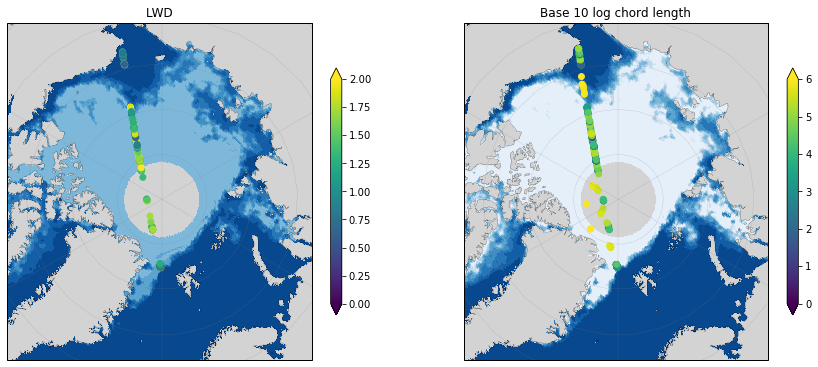

In [13]:
# What variable to plot 

cvar='Lead Width (log)'


cmap_c = matplotlib.colors.ListedColormap(sns.color_palette("Blues_r", 10))
cmap_c.set_bad(color = 'lightgrey')
central_extent = [-3850000*0.6, 3725000*0.6, -5325000*0.45, 5850000*0.45] # (x0, x1, y0, y1

# (f, axes) = ice_plot.multi_polar_axis(ncols=1, nrows=2, Nplots=4, sizefcter=5, extent=central_extent, central_longitude=0)
(f, axes) = ice_plot.multi_polar_axis(ncols=2, nrows=2, Nplots=3,sizefcter=5,extent=central_extent, central_longitude=0)

print(axes)
i=0
obs_h1 = obs_thick.plot.pcolormesh(ax=axes[i], x='longitude', y='latitude', 
                      transform=ccrs.PlateCarree(),
                      add_colorbar=False,
                      cmap=cmap_c,
                      vmin=0, vmax=2.5)

# put on the track
Lead_Track = axes[0].scatter(lonlead, latlead, c=np.log10(LWD), cmap='viridis', transform=ccrs.PlateCarree(),vmin=0, vmax=2)
axes[0].set_title('LWD');
f.colorbar(Lead_Track,ax=axes[0],shrink=0.5,extend='both')

i=1
obs_h2 = obs_thick.plot.pcolormesh(ax=axes[i], x='longitude', y='latitude', 
                      transform=ccrs.PlateCarree(),
                      add_colorbar=False,
                      cmap=cmap_c,
                      vmin=0, vmax=1)

# put on the track
Chord_Track = axes[1].scatter(lonfloe, latfloe, c=np.log10(CLD), cmap='viridis', transform=ccrs.PlateCarree(),vmin=0, vmax=6)
axes[1].set_title('Base 10 log chord length');
f.colorbar(Chord_Track,ax=axes[1],shrink=0.5,extend='both')

# Save
# axes[i].title('CLD')
# f_out = os.path.join(fig_dir,ATL07file+'_seg_lengths.png')
# print(f_out)
# plt.savefig(f_out,bbox_inches='tight', dpi=200)

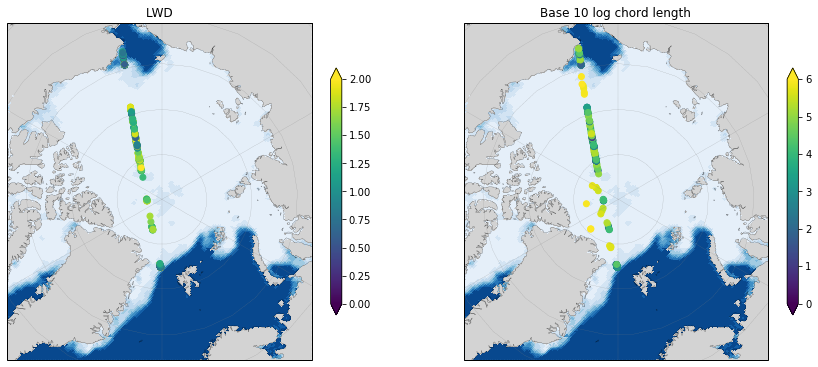

In [20]:
cmap_c = matplotlib.colors.ListedColormap(sns.color_palette("Blues_r", 10))
cmap_c.set_bad(color = 'lightgrey')
central_extent = [-3850000*0.6, 3725000*0.6, -5325000*0.45, 5850000*0.45] # (x0, x1, y0, y1

(f, axes) = ice_plot.multi_polar_axis(ncols=2, nrows=2, Nplots=3,sizefcter=5,extent=central_extent, central_longitude=0)

print(axes)
i=0
obs_h1 = obs_sic.plot.pcolormesh(ax=axes[i], x='lon', y='lat', 
                      transform=ccrs.PlateCarree(),
                      add_colorbar=False,
                      cmap=cmap_c,
                      vmin=0, vmax=1)

# put on the track
Lead_Track = axes[0].scatter(lonlead, latlead, c=np.log10(LWD), cmap='viridis', transform=ccrs.PlateCarree(),vmin=0, vmax=2)
axes[0].set_title('LWD');
f.colorbar(Lead_Track,ax=axes[0],shrink=0.5,extend='both')

# f.colorbar(track, label=cvar, shrink=0.5, extend='both')
# cbar_ax = f.add_axes([0.55, 0.325, 0.015, 0.35])
# cbar = f.colorbar(obs_h, cax=cbar_ax, label='Sea Ice Concentration', orientation='vertical')

i=1
obs_h2 = obs_sic.plot.pcolormesh(ax=axes[i], x='lon', y='lat', 
                      transform=ccrs.PlateCarree(),
                      add_colorbar=False,
                      cmap=cmap_c,
                      vmin=0, vmax=1)

# put on the track
Chord_Track = axes[1].scatter(lonfloe, latfloe, c=np.log10(CLD), cmap='viridis', transform=ccrs.PlateCarree(),vmin=0, vmax=6)
axes[1].set_title('Base 10 log chord length');
f.colorbar(Chord_Track,ax=axes[1],shrink=0.5,extend='both')

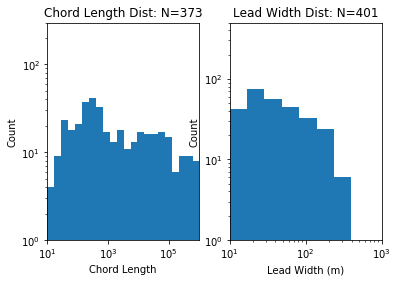

In [21]:
xbuckets = np.logspace(1, 9, num=36, endpoint=True, base=10.0, dtype=None)
hist,edges = np.histogram(CLD,xbuckets)

fig, ax2 = plt.subplots(1, 2);
ax2[0].hist(CLD,bins=edges);
ax2[0].set(yscale='log',xscale='log',xlim=(1e1,1e6),ylim=(1,300),xlabel='Chord Length',ylabel='Count',title='Chord Length Dist: N=' + str(len(CLD)));

ax2[1].hist(LWD,bins=edges);
ax2[1].set(yscale='log',xscale='log',xlim=(1e1,1e3),ylim=(1,500),xlabel='Lead Width (m)',ylabel='Count',title='Lead Width Dist: N=' + str(len(LWD)));

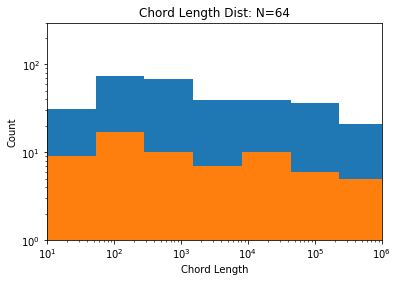

In [68]:
inbering = (latfloe < 75 )
CLD_bering = CLD[inbering] 
lon_bering = lonfloe[inbering]
lat_bering = latfloe[inbering]

incenter = latfloe > 75

CLD_rest = CLD[incenter]
lon_rest = lonfloe[incenter]
lat_rest = latfloe[incenter]

xbuckets = np.logspace(1, 9, num=12, endpoint=True, base=10.0, dtype=None)
hist,edges = np.histogram(CLD_bering,xbuckets)

fig, ax = plt.subplots(1, 1);

ax.hist(CLD_rest,bins=edges)
ax.hist(CLD_bering,bins=edges);

ax.set(yscale='log',xscale='log',xlim=(1e1,1e6),ylim=(1,300),xlabel='Chord Length',ylabel='Count',title='Chord Length Dist: N=' + str(len(CLD_bering)));


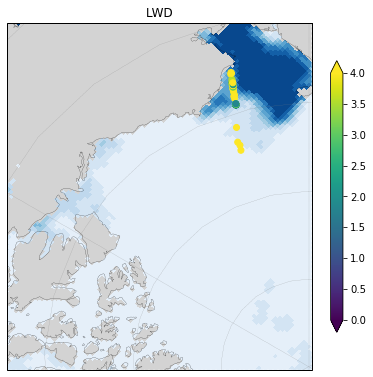

In [52]:
cmap_c = matplotlib.colors.ListedColormap(sns.color_palette("Blues_r", 10))
cmap_c.set_bad(color = 'lightgrey')
central_extent = [-3850000*0.6, 37250*0.6, -53250*0.45, 5850000*0.45] # (x0, x1, y0, y1

(f, axes) = ice_plot.multi_polar_axis(ncols=2, nrows=1, Nplots=2,sizefcter=5,extent=central_extent, central_longitude=0)

print(axes)
i=0
obs_h1 = obs_sic.plot.pcolormesh(ax=axes[i], x='lon', y='lat', 
                      transform=ccrs.PlateCarree(),
                      add_colorbar=False,
                      cmap=cmap_c,
                      vmin=0, vmax=1)

# put on the track
Lead_Track = axes[0].scatter(lon_bering, lat_bering, c=np.log10(CLD_bering), cmap='viridis', transform=ccrs.PlateCarree(),vmin=0, vmax=4)
axes[0].set_title('CLD');
f.colorbar(Lead_Track,ax=axes[0],shrink=0.5,extend='both')

# f.colorbar(track, label=cvar, shrink=0.5, extend='both')
# cbar_ax = f.add_axes([0.55, 0.325, 0.015, 0.35])
# cbar = f.colorbar(obs_h, cax=cbar_ax, label='Sea Ice Concentration', orientation='vertical')


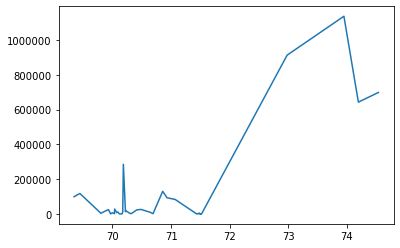

In [54]:
i_array = np.argsort(lat_bering)

plt.plot(lat_bering[i_array],CLD_bering[i_array])